### Download the data

In [2]:
##Import the libraries
from bs4 import BeautifulSoup
import pandas as pd
import urllib2
from collections import defaultdict
%matplotlib inline

In [3]:
##Get the staion data
URL="https://s3.amazonaws.com/capitalbikeshare-data/index.html"
URL2="https://feeds.capitalbikeshare.com/stations/stations.xml"

#Stations
stationsXML=BeautifulSoup(urllib2.urlopen(URL2), "lxml")
test=[]
for station in stationsXML.find_all('station'):
    tempStation={}
    for stationType in station:
        tempStation[stationType.name]=stationType.text
    test.append(tempStation)
#Creates pandas structure and gives format
stations=pd.DataFrame(test).set_index('id')
stations.drop(['installdate', 'installed', 'locked', 'public', 'lastcommwithserver', 'temporary', 'removaldate', 'latestupdatetime'], axis=1, inplace=True)

stations.nbbikes=stations.nbbikes.astype('int')
stations.nbemptydocks=stations.nbemptydocks.astype('int')
stations.lat=stations.lat.astype('float64')
stations.long=stations.long.astype('float64')

stations['nbdocks']=pd.Series(stations.nbbikes+stations.nbemptydocks, index=stations.index)

In [4]:
#Get tge top N stations
topStations=stations[['name', 'nbdocks']].sort_values('nbdocks', ascending=False).head(7)
topStations.to_html(index=False, classes='table', border=0)

u'<table border="0" class="dataframe table">\n  <thead>\n    <tr style="text-align: right;">\n      <th>name</th>\n      <th>nbdocks</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td>Columbus Circle / Union Station</td>\n      <td>42</td>\n    </tr>\n    <tr>\n      <td>Massachusetts Ave &amp; Dupont Circle NW</td>\n      <td>39</td>\n    </tr>\n    <tr>\n      <td>1st &amp; N St  SE</td>\n      <td>39</td>\n    </tr>\n    <tr>\n      <td>USDA / 12th &amp; Independence Ave SW</td>\n      <td>39</td>\n    </tr>\n    <tr>\n      <td>Maryland &amp; Independence Ave SW</td>\n      <td>37</td>\n    </tr>\n    <tr>\n      <td>17th &amp; K St NW / Farragut Square</td>\n      <td>35</td>\n    </tr>\n    <tr>\n      <td>Reston Station</td>\n      <td>34</td>\n    </tr>\n  </tbody>\n</table>'

In [5]:
#Download data from rides
##PENDING IMPLEMENTATION
testCase='https://s3.amazonaws.com/capitalbikeshare-data/2015-Q1-cabi-trip-history-data.zip'

In [6]:
##Read zip file
import zipfile
#extract csv
zip_ref = zipfile.ZipFile('Exclude/2015-Q1-cabi-trip-history-data.zip', 'r')
zip_ref.extractall('Exclude/')
#Read csv into pandas
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M')
trip2015Q1=pd.read_csv('Exclude/2015-Q1-Trips-History-Data.csv', parse_dates=['Start date', 'End date'], date_parser=dateparse)

#Perform any additinal columns
trip2015Q1['day']=trip2015Q1['Start date'].dt.dayofweek
trip2015Q1['hour']=trip2015Q1['Start date'].dt.hour
trip2015Q1.head(5)

,Total duration (ms),Start date,Start station,End date,End station,Bike number,Subscription Type,day,hour
0,2394764,2015-01-01 00:02:00,Constitution Ave & 2nd St NW/DOL,2015-01-01 00:42:00,15th & K St NW,W00612,Casual,3,0
1,2389161,2015-01-01 00:02:00,Constitution Ave & 2nd St NW/DOL,2015-01-01 00:42:00,15th & K St NW,W01140,Casual,3,0
2,468047,2015-01-01 00:04:00,20th & E St NW,2015-01-01 00:12:00,20th & O St NW / Dupont South,W01226,Registered,3,0
3,348068,2015-01-01 00:07:00,Park Rd & Holmead Pl NW,2015-01-01 00:13:00,15th & Euclid St NW,W20216,Registered,3,0
4,980844,2015-01-01 00:09:00,Jefferson Dr & 14th St SW,2015-01-01 00:25:00,Thomas Circle,W21005,Casual,3,0


In [7]:
#Add to the stations the number of arrivales and departures
totDias=(trip2015Q1['Start date'].max()-trip2015Q1['Start date'].min()).days
groupedStart=trip2015Q1.groupby(by='Start station')['Start date'].count().to_frame()
groupedEnded=trip2015Q1.groupby(by='End station')['Start date'].count().to_frame()
stationsTrips=pd.merge(groupedStart, groupedEnded, how='outer', left_index=True, right_index=True)
stationsTrips.columns=['Departure', 'Arrival']
stationsTrips['DepartureRate']=stationsTrips['Departure']/totDias
stationsTrips['ArrivalRate']=stationsTrips['Arrival']/totDias
stationsTrips.sort_values(by='Departure', ascending=False, inplace=True)
stationsTrips.head(5)

,Departure,Arrival,DepartureRate,ArrivalRate
Columbus Circle / Union Station,11194.0,11589,125.775281,130.213483
Massachusetts Ave & Dupont Circle NW,7453.0,9529,83.741573,107.067416
15th & P St NW,6526.0,7502,73.325843,84.292135
New Hampshire Ave & T St NW,6026.0,5315,67.707865,59.719101
Thomas Circle,6018.0,5573,67.617978,62.617978


### Plot  to understand the data

In [8]:
import seaborn as sns

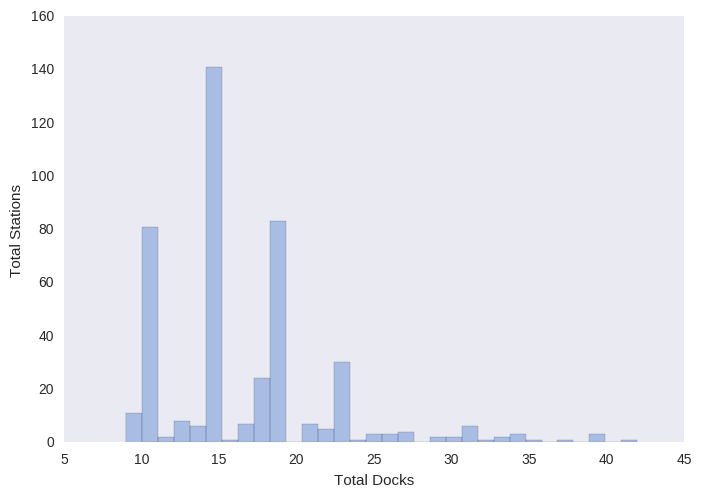

In [18]:
sns.set_style("dark")
sns.color_palette("hls", 8)
diPlot=sns.distplot(stations.nbdocks, kde=False);
diPlot.set(xlabel='Total Docks', ylabel='Total Stations')
diPlot.figure.savefig('static/img/distStations.png')

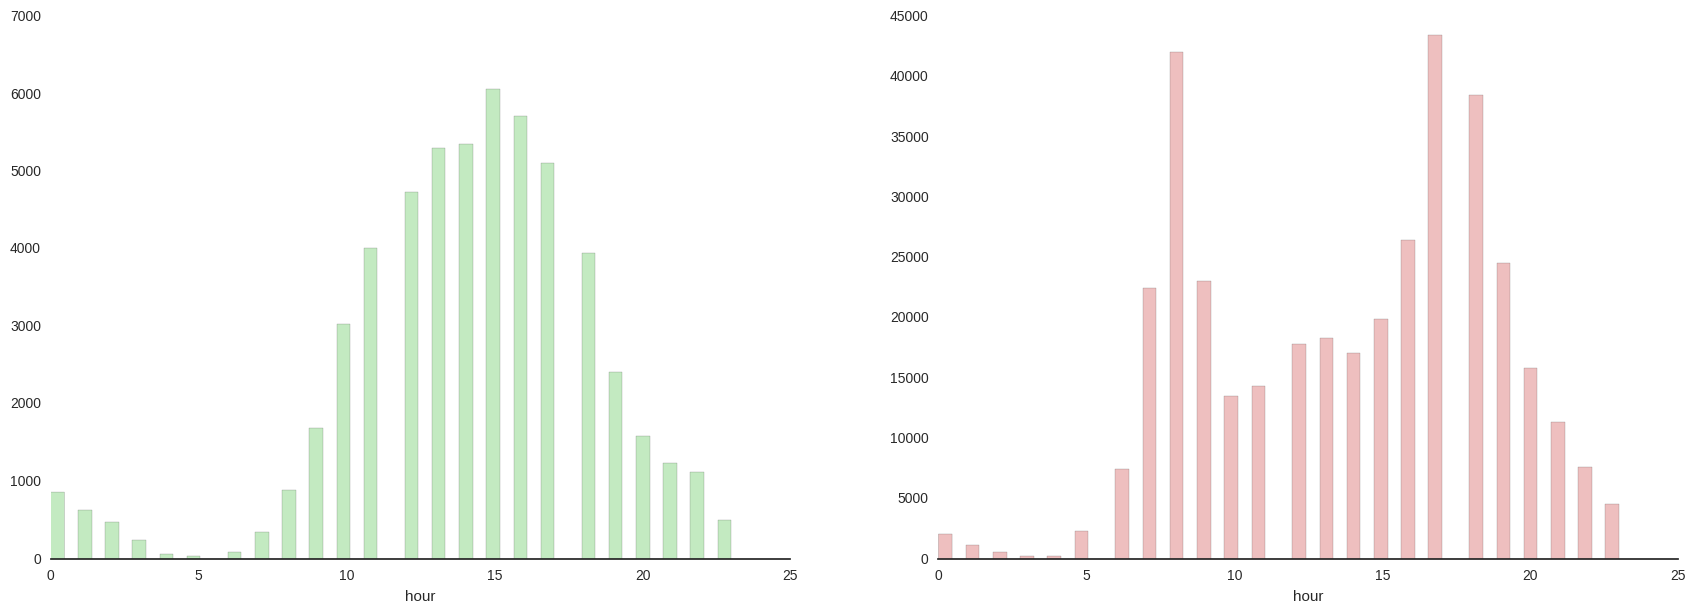

In [36]:
import matplotlib.pyplot as plt 
## Create distribution of Days vs. Weekends rides on hours
weekEndRides=trip2015Q1[trip2015Q1['day']>=6]['hour']
weekDayRides=trip2015Q1[trip2015Q1['day']<6]['hour']

sns.set(style="white", palette="muted", color_codes=True)

fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.despine(left=True)

sns.distplot(weekEndRides, kde=False, color='g', ax=ax1)
sns.distplot(weekDayRides, kde=False, color='r', ax=ax2)

#distWeekD=sns.distplot(weekEndRides, kde=False, color="g")
#distWeekE=sns.distplot(weekDayRides, kde=False, color="g")

#distWeekD.figure.savefig('static/img/distWeekD.png')
#distWeekE.figure.savefig('static/img/distWeekE.png')
fig.savefig('static/img/distWeeks.png')


In [ ]:
## Create distribution of Days vs. Weekends rides on hours

# sns.set(style="white", palette="muted", color_codes=True)
# sns.distplot(weekEndRides, kde=False)

#distWeekD=sns.distplot(weekEndRides, kde=False, color="g")
#distWeekE=sns.distplot(weekDayRides, kde=False, color="g")

#distWeekD.figure.savefig('static/img/distWeekD.png')
#distWeekE.figure.savefig('static/img/distWeekE.png')